In [1]:
# load and process data
import os,gc
# import sys
from importlib import reload
import torch
import numpy as np
# import matplotlib.pyplot as plt

from wbtool.show import wshow
from wbtool import file_misc as fm
import proc_data,aux

vid = np.load('/home/wb/samba_dir/cells_brightfield/leadingcell-WB-entirespan/B1ROI1.npy')
# vid = np.load('/home/wb/samba_dir/cells_brightfield/leading-HELA-entirespan/A1ROI1.npy')
# vid = np.load('/home/wb/samba_dir/cells_brightfield/single-cell-movement-for-machine-learning/A549/0/A4ROI1.npy')
# vid = np.load('/home/wb/samba_dir/cells_brightfield/temp/A4ROI1.npy')  # difficult
# vid = vid[:5]

vid = proc_data.value_modify(vid)
vid = proc_data.ch_num_modify(vid)
# print(vid.shape)

ids,coords = proc_data.read_coords_from_csv('/home/wb/samba_dir/cells_brightfield/leadingcell-WB-entirespan/Results_B1ROI1.csv')
# ids,coords = proc_data.read_coords_from_csv('/home/wb/samba_dir/cells_brightfield/leading-HELA-entirespan/Results_A1ROI1.csv')
# ids,coords = proc_data.read_coords_from_csv('/home/wb/samba_dir/cells_brightfield/single-cell-movement-for-machine-learning/A549/0/Results_A4ROI1.csv')
# ids,coords = proc_data.read_coords_from_csv('/home/wb/samba_dir/cells_brightfield/temp/Results from A4ROI1_02_1_1_Bright Field in µm per sec.csv')

# output masks
output_dir = '/home/wb/samba_dir/indev/results' #io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

/home/wb/apps/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(904, 1224, 3)


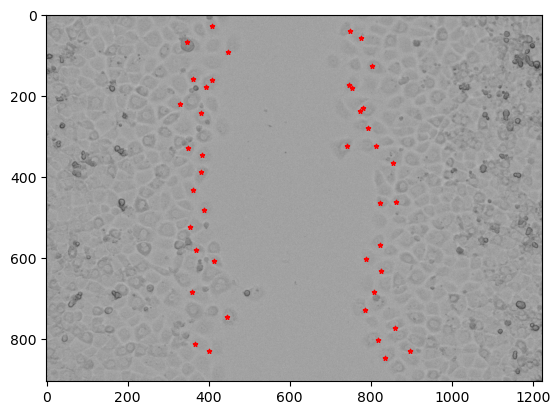

In [2]:
from wbtool import show 

fid = 18
point_prompt = coords[fid]
obj_mode = np.ones((len(point_prompt), 1))
frame = vid[fid]
frame = proc_data.value_modify(frame)
print(frame.shape)

show.overlay_point(frame, point_prompt)

In [3]:
# for segmentation
# reload(aux)
import SegTracker
from wbtool import use_models
from model_args import aot_args,sam_args #,segtracker_args

# print(sam_args)
# sam_args['generator_args'] = {
#         'points_per_side': 30,
#         'pred_iou_thresh': 0.8,
#         'stability_score_thresh': 0.9,
#         'crop_n_layers': 1,
#         'crop_n_points_downscale_factor': 2,
#         'min_mask_region_area': 200,
#     }

segtracker_args = {
    'sam_gap': 1, # the interval to run sam to segment new objects
    'min_area': 20, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
    'new_replace_iou_min': 0.5,
    'remain_remove_max':0.4,
    'min_obj_area_ratio':0.0001,
    'max_obj_area_ratio':0.01
}

# tool models.
SA = use_models.cv.sam_agent('prompt')
segtracker = SegTracker.SegTracker(segtracker_args, sam_args, aot_args)

/home/wb/apps/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/wb/tools/Segment-and-Track-Anything/ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized


In [5]:
# === get segmentation results of each frame.
# (this is independent of tracking activity)
# reload(aux)
use_saved = False
file = os.path.join(output_dir,'../sms.pk')

if use_saved:
    seg_list = fm.pload(file)
else:    
    seg_list = aux.do_segment(SA, segtracker_args, vid, ids, coords)
    fm.pdump(file, seg_list)

segment for frame 40
-segmentation done


In [17]:
### Generate Results for the Whole Video
# importlib.reload(SegTracker)
# from skimage import morphology
# from onevision import morphology as ovmorph
from onevision import morph_data
# from wbtool import show
# reload(aux)
# reload(proc_data)
# reload(morph_data)
# reload(ovmorph)

# grounding_caption = "cell"
# box_threshold, text_threshold, box_size_threshold, reset_image = 0.02, 0.02, 0.05, True

# === tracking
flag_do_backward = False
# segtracker = SegTracker.SegTracker(segtracker_args, sam_args, aot_args)
segtracker.restart_tracker()   # 调用的是aot_tracker/AOTTracker function, AOT模型自身的restart要求.
fnum = len(vid)

torch.cuda.empty_cache()
gc.collect()
pred_list = []; track_list = []; #sm2=[]; sm1=[]
# with torch.cuda.amp.autocast():
for frame_idx in range(fnum):
    frame = vid[frame_idx]
    track_list.append(None)
    if frame_idx == 0:
        # print(segtracker.curr_idx)
        pred_mask = morph_data.imbind_to_map(seg_list[frame_idx])
        segtracker.add_reference(frame, pred_mask)
    elif (frame_idx % segtracker_args['sam_gap']) == 0:
        # 1/2
        seg_mask = seg_list[frame_idx]
        # 2/2
        # seg_mask,_ = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold, reset_image)
        # e/2

        # torch.cuda.empty_cache()
        # gc.collect()
        track_mask = segtracker.track(frame)
        
        track_mask = morph_data.IMbind(track_mask, 'map')
        # print('track output', track_mask.ids)
        track_mask = aux.isolate_filter_object(track_mask, segtracker_args)
        track_list[frame_idx] = track_mask
        # print('k7') #('before st ', track_mask.ids)
        pred_mask = aux.merge_st(segtracker_args, track_mask, seg_mask)
        # print('k8') #('after st ', pred_mask)
        pred_mask = morph_data.imbind_to_map(pred_mask)
        # print('k10') #('merged ', list(np.unique(pred_mask)))
        
        # segtracker.restart_tracker()
        segtracker.add_reference(frame, pred_mask)
    else:
        pred_mask = segtracker.track(frame, update_memory=True)
    pred_list.append(pred_mask)
    # gc.collect()
    proc_data.save_prediction(pred_mask, output_dir, str(frame_idx)+'.png', opt='overlay', image=frame)    
    print("processed frame {}, obj_num {}".format(frame_idx, segtracker.get_obj_num()), end='\r')
print('\n-forward tracking finished')
fm.pdump(os.path.join(output_dir,'../tms.pk'), track_list)
fm.pdump(os.path.join(output_dir,'../pms.pk'), pred_list)

# == backward merge part.
if flag_do_backward:
    for frame_idx in range(fnum-2, -1, -1):
        print(frame_idx)
        frame = vid[frame_idx]

        if (frame_idx % segtracker_args['sam_gap']) == 0:
            # 1/2
            seg_mask = pred_list[frame_idx]
            # 2/2
            # seg_mask,_ = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold, reset_image)
            # e/2

            # torch.cuda.empty_cache()l
            # gc.collect()
            track_mask = segtracker.track(frame)
            track_mask = morph_data.IMbind(track_mask, 'map')
            track_mask = aux.isolate_filter_object(track_mask, segtracker_args)
            # track_list[frame_idx] = track_mask
            pred_mask = aux.merge_st(segtracker_args, track_mask, seg_mask)
            pred_mask = morph_data.imbind_to_map(pred_mask)

            # segtracker.restart_tracker()
            segtracker.add_reference(frame, pred_mask)
        else:
            pass

        proc_data.save_prediction(pred_mask, output_dir, str(frame_idx)+'.png', opt='overlay', image=frame)    
        print("processed frame {}, obj_num {}".format(frame_idx, segtracker.get_obj_num()), end='\r')
    print('\n-backward tracking finished')


most overlap not 18 but 2m 35
most overlap not 35 but 2
most overlap not 18 but 2m 35
processed frame 4, obj_num 35
-forward tracking finished


In [17]:
def expe(imbs):
    fnum = len(imbs)
    onum = 45
    SA = []
    for oi in range(1, onum+1):
        S = []
        for fi in range(fnum):
            if oi in imbs[fi].ids:
                area = np.sum(imbs[fi][oi])
            else:
                area = 0
            S.append(area)
        SA.append(S)
    return SA

31
<class 'onevision.morphology.IMbind'>
IMbind with 43 obj with ids (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43)
image shape:(904, 1224)


供参考的SegTracker函数

刘平版：
def detect_and_seg_pt(self, origin_frame: np.ndarray, coords, modes):
    '''
    Using Grounding-DINO to detect object acc Text-prompts
    Retrun:
        refined_merged_mask: numpy array (h, w)
        annotated_frame: numpy array (h, w, 3)
    '''
            # backup id and origin-merged-mask
    bc_id = self.curr_idx
    bc_mask = self.origin_merged_mask
    
    # get annotated_frame and boxes
    # annotated_frame, boxes = self.detector.run_grounding(origin_frame, grounding_caption, box_threshold, text_threshold)
    for i in range(len(coords)):
        pt = coords[i].reshape([1,2])
        mode = modes[i]
        # if (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1]) > annotated_frame.shape[0] * annotated_frame.shape[1] * box_size_threshold:
        #     continue
        interactive_mask = self.sam.segment_with_click(origin_frame, pt, mode)

        mask = interactive_mask.copy()
        if(mask.sum(1).sum(0)/(mask.shape[0]*mask.shape[1]) < 0.01): 
            refined_merged_mask = self.add_mask(interactive_mask)
            self.update_origin_merged_mask(refined_merged_mask)
            self.curr_idx += 1

    # reset origin_mask
    self.reset_origin_merged_mask(bc_mask, bc_id)

    return refined_merged_mask

最终版：
    def detect_and_seg_pt(self, frame: np.ndarray, coords, modes):
        '''
        Using Grounding-DINO to detect object acc Text-prompts
        Retrun:
            refined_merged_mask: numpy array (h, w)
            annotated_frame: numpy array (h, w, 3)
        '''
        # backup id and origin-merged-mask
        bc_id = self.curr_idx
        bc_mask = self.origin_merged_mask
    
        # get annotated_frame and boxes
        # annotated_frame, boxes = self.detector.run_grounding(frame, grounding_caption, box_threshold, text_threshold)
        cnum = len(coords)
        imgarea = frame.shape[0]*frame.shape[1]
        # ims = []
        refined_merged_mask = self.add_mask(np.zeros(frame.shape[:2], dtype=np.uint8))
        for k in range(cnum):
            # if (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1]) > annotated_frame.shape[0] * annotated_frame.shape[1] * box_size_threshold:
            #     continue
            interactive_mask = self.sam.segment_with_click(frame, coords[k:k+1], modes[k], True)
            # ims.append(interactive_mask.copy())
            
            if interactive_mask.sum(1).sum(0)/imgarea < 0.01:
                refined_merged_mask = self.add_mask(interactive_mask)  #在self.origin_merged_mask 的基础上，根据输入修改得到返回值。
                self.update_origin_merged_mask(refined_merged_mask)
                self.curr_idx += 1

        # reset origin_mask
        self.reset_origin_merged_mask(bc_mask, bc_id)

        return refined_merged_mask